## Hindi TTS Interactive notebook using Tacotron 2 and Waveglow

In this notebook, we will be using our checkpoint file of the training notebook we ran previously and use the WaveGlow decoder to get the final output of Hindi Text to Speech.

WaveGlow is a flow-based network capable of generating high-quality speech from mel spectrograms. In its true sense, it is a generative model that generates audio by sampling from a distribution. To use a neural network as a generative model, we take samples from a simple distribution, in our case, a zero mean spherical Gaussian with the same number of dimensions as our desired output, and put those samples through a series of layers that transforms the simple distribution to one which has the desired distribution. In this case, we model the distribution of audio samples conditioned on a mel spectrogram.


#### Step 1: Import libraries and setup matplotlib

In [16]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

#### Step 2: Setting up the mel spectrogram plotting function and calling the hyperparamater generator in its default setting

In [17]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Step 3: Load model from checkpoint

In [18]:
hparams = create_hparams()
hparams.sampling_rate = 22050

In [19]:
checkpoint_path = "C:\\Users\\vinee\\Downloads\\checkpoint_4400"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Step 4: Load WaveGlow for mel2audio synthesis and denoiser

In [20]:
waveglow_path = 'D:\\waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Step 5: Prepare text input

In [30]:
text = "दो साल बाद भी जारी है" # mei bazaar jaa raha hu
#text = "भारत एक विशाल देश है जिसकी आबादी बहुत बड़ी है"
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Step 6: Decode text input and plot results

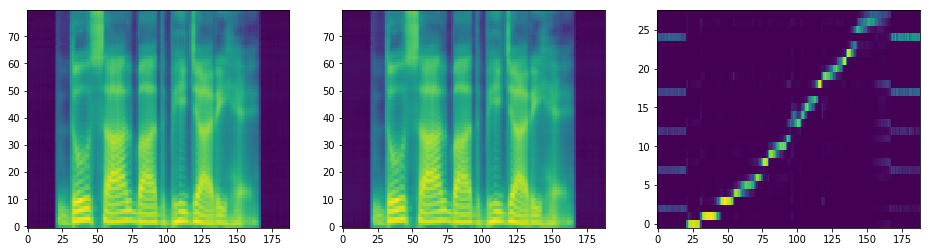

In [31]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### A short summary about melspectrograms

Sound is heard as a result of the variation of pressure with time. However, speech signals are complex entities and a simple pressure variation does not capture enough information for the deep learning model to be trained. Hence in short, a melspectrogram, is a graph which plots three quanitites - Time on the X axis, Frequency on the Y axis and the colors represent the loudness of the sound. 

The alignment graph seen above is a simple representation of the trajectory of the final output compared to its initial text input

#### Step 7: Synthesize audio from spectrogram using WaveGlow

In [32]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### References

1. "Natural TTS Synthesis by Conditioning WaveNet on Mel Spectrogram Predictions" - Shen et al, ICASSP 2018

2. "WaveGlow: A Flow-based Generative Network for Speech Synthesis" - Prenger et al, ICASSP 2019

3. Indic TTS Databasee - IIT Madras : https://www.iitm.ac.in/donlab/tts/index.php

4. Blog on English TTS Using Tacotron 2 and WaveGlow by Nvidia: https://developer.nvidia.com/blog/generate-natural-sounding-speech-from-text-in-real-time/

5. Tacotron 2 Github: https://github.com/NVIDIA/tacotron2

6. WaveGlow Github: https://github.com/NVIDIA/waveglow